In [1]:
from sklearn.linear_model import LogisticRegression
from IPython.display import HTML
from tqdm import tqdm_notebook
import sys; sys.path.append('paper')
from initialize import * # user settings: feel free to change

data, scaler = load_data() # helper function to load in a dictionary containing our dataset.
data['X'].head()

,Married,Single,Age_lt_25,Age_in_25_to_40,Age_in_40_to_59,...,MostRecentBillAmount,MostRecentPaymentAmount,TotalOverdueCounts,TotalMonthsOverdue,HistoryOfOverduePayments
0,1,0,1,0,0,...,120,0,1,4,1
1,0,1,0,1,0,...,80,0,2,4,1
2,0,1,0,1,0,...,890,50,0,0,0
3,1,0,0,1,0,...,1430,60,0,0,0
4,1,0,0,0,1,...,260,60,0,0,0


In [2]:
from paper.initialize import *

# user settings
settings = {
    #
    # audit settings
    'data_name': 'credit',
    'method_name': 'logreg',
    'normalize_data': True,
    'force_rational_actions': False,
    #
    # script flags
    'audit_recourse': True,
    'plot_audits': True,
    'print_flag': True,
    'save_flag': True,
    'randomseed': 2338,
    #
    # placeholders
    'method_suffixes': [''],
    'audit_suffixes': [''],
    }


In [3]:
	# file names
output_dir = results_dir / settings['data_name']
output_dir.mkdir(exist_ok = True)

if settings['normalize_data']:
    settings['method_suffixes'].append('normalized')

if settings['force_rational_actions']:
    settings['audit_suffixes'].append('rational')

# set file header
settings['dataset_file'] = '%s/%s_processed.csv' % (data_dir, settings['data_name'])
settings['file_header'] = '%s/%s_%s%s' % (output_dir, settings['data_name'], settings['method_name'], '_'.join(settings['method_suffixes']))
settings['audit_file_header'] = '%s%s' % (settings['file_header'], '_'.join(settings['audit_suffixes']))
settings['model_file'] = '%s_models.pkl' % settings['file_header']
settings['audit_file'] = '%s_audit_results.pkl' % settings['audit_file_header']
pp.pprint(settings)

# data set
data_df = pd.read_csv(settings['dataset_file'])
data = {
    'outcome_name': data_df.columns[0],
    'variable_names': data_df.columns[1:].tolist(),
    'X': data_df.iloc[:, 1:],
    'y': data_df.iloc[:, 0]
    }

scaler = None
data['X_train'] = data['X']
data['scaler'] = None
if settings['normalize_data']:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler(copy = True, with_mean = True, with_std = True)
    data['X_scaled'] = pd.DataFrame(scaler.fit_transform(data['X'].to_numpy(dtype = float), data['y'].values), columns = data['X'].columns)
    data['X_train'] = data['X_scaled']
    data['scaler'] = scaler

{   'audit_file': 'C:\\Users\\swang8\\Desktop\\Research\\Project\\2\\reproduce_action_linear\\3\\examples\\paper\\results\\credit/credit_logreg_normalized_audit_results.pkl',
    'audit_file_header': 'C:\\Users\\swang8\\Desktop\\Research\\Project\\2\\reproduce_action_linear\\3\\examples\\paper\\results\\credit/credit_logreg_normalized',
    'audit_recourse': True,
    'audit_suffixes': [''],
    'data_name': 'credit',
    'dataset_file': 'C:\\Users\\swang8\\Desktop\\Research\\Project\\2\\reproduce_action_linear\\3\\examples\\paper\\data/credit_processed.csv',
    'file_header': 'C:\\Users\\swang8\\Desktop\\Research\\Project\\2\\reproduce_action_linear\\3\\examples\\paper\\results\\credit/credit_logreg_normalized',
    'force_rational_actions': False,
    'method_name': 'logreg',
    'method_suffixes': ['', 'normalized'],
    'model_file': 'C:\\Users\\swang8\\Desktop\\Research\\Project\\2\\reproduce_action_linear\\3\\examples\\paper\\results\\credit/credit_logreg_normalized_models.pkl',

# Set up our Actionset

In [4]:
default_bounds = (1.0, 99.0, 'percentile')
custom_bounds = None
immutable_variables = []
if settings['data_name'] == 'credit':
    ## set features in our input data that are immutable: 
    ##     i.e. individuals will not be asked to change any of these 
    ##          variables when the optimizer seeks recourse.
    immutable_names = ['Female', 'Single', 'Married']
    immutable_names += list(filter(lambda x: 'Age' in x or 'Overdue' in x, data['variable_names']))
    data['immutable_variable_names'] = [n for n in immutable_names if n in data['variable_names']]

    ## set the default and custom bounds we wish to search over.
    default_bounds = (0.1, 99.9, 'percentile')
    custom_bounds = {'Female': (0, 100, 'p'),  'Married': (0, 100, 'p')}
    
    ## 
    action_set = ActionSet(X = data['X'], custom_bounds = custom_bounds, default_bounds = default_bounds)
    
    for immutable_var in data['immutable_variable_names']:
        action_set[immutable_var].mutable = False 
    #action_set[data['immutable_variable_names']].mutable = False

    ## set other custom behaviors in each of the data types.
    action_set['EducationLevel'].step_direction = 1
    payment_fields = list(filter(lambda x: 'Amount' in x, data['variable_names']))
    action_set[payment_fields].step_type = 'absolute'
    action_set[payment_fields].step_size = 50

    for p in payment_fields:
        action_set[p].update_grid()


# Generate a Flipset

In [5]:
# model
model_stats = pickle.load(open(settings['model_file'], 'rb'))

# need the file -> 
# paper/results/credit -> credit_logreg_normalized_models.pkl 

all_models = model_stats.pop('all_models')

### Create Flipset
clf = all_models['C_0.02__max_iter_1000__penalty_l1__solver_saga__tol_1e-08']
yhat = clf.predict(X = data['X_train'])
coefficients, intercept = undo_coefficient_scaling(clf, scaler = data['scaler'])

action_set.set_alignment(coefficients)
#action_set.align(coefficients)

predicted_neg = np.flatnonzero(yhat < 1)
U = data['X'].iloc[predicted_neg].values
k = 4
fb = Flipset(x = U[k], action_set = action_set, coefficients = coefficients, intercept = intercept)
fb.populate(enumeration_type = 'distinct_subsets', total_items = 14)
print(fb)


obtained 14 items in 0.8 seconds
        cost size                                           features  \
0   0.393580    1                               [TotalMonthsOverdue]   
1   0.416325    2  [MaxPaymentAmountOverLast6Months, TotalMonthsO...   
2   0.417554    2  [MaxBillAmountOverLast6Months, TotalMonthsOver...   
4   0.703737    2      [MostRecentPaymentAmount, TotalMonthsOverdue]   
8   1.117688    2  [MonthsWithZeroBalanceOverLast6Months, TotalMo...   
3   0.440300    3  [MaxBillAmountOverLast6Months, MaxPaymentAmoun...   
5   0.726483    3  [MaxPaymentAmountOverLast6Months, MostRecentPa...   
6   0.727712    3  [MaxBillAmountOverLast6Months, MostRecentPayme...   
9   1.140434    3  [MaxPaymentAmountOverLast6Months, MonthsWithZe...   
10  1.141663    3  [MaxBillAmountOverLast6Months, MonthsWithZeroB...   
12  1.427846    3  [MonthsWithZeroBalanceOverLast6Months, MostRec...   
7   0.750457    4  [MaxBillAmountOverLast6Months, MaxPaymentAmoun...   
11  1.164409    4  [MaxBillAmou

In [6]:
from IPython.display import HTML
HTML(fb.to_html())

Features to Change,Current Value,to,Required Value
TotalMonthsOverdue,11,→,9
MaxPaymentAmountOverLast6Months,40,→,50
TotalMonthsOverdue,11,→,9
MaxBillAmountOverLast6Months,50,→,100
TotalMonthsOverdue,11,→,9
TotalMonthsOverdue,11,→,9
MaxBillAmountOverLast6Months,50,→,100
MaxPaymentAmountOverLast6Months,40,→,50
TotalMonthsOverdue,11,→,9
MostRecentPaymentAmount,0,→,50


## Train classifiers

In [7]:
from copy import deepcopy as copy 
from sklearn.model_selection import StratifiedKFold as CVGenerator
from sklearn.model_selection import GridSearchCV


cv_generator = CVGenerator(n_splits = 10, random_state = settings['randomseed'], shuffle = True)

# this code is for general purpose train/test evaluation using GridSearchCV
gridsearch = GridSearchCV(
    # original: [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
    clf, param_grid={"C":[1.0 / l for l in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]]},
    #clf, param_grid={"C":[1.0 / l for l in [1, 2, 5,]]},
    scoring='neg_mean_squared_error',
    return_train_score=True,
    cv=cv_generator,
    verbose=1,
    n_jobs=-1
)

if settings['normalize_data']:
    gridsearch.fit(data['X_scaled'], data['y'])
else:
    gridsearch.fit(data['X'], data['y'])
grid_search_df = pd.DataFrame(gridsearch.cv_results_)


# cache a model for each parameter combination, trained on all data
model_dict = {}
grid_search_df['key'] = pd.np.nan
for idx, p in tqdm_notebook(list(grid_search_df.params.iteritems())):
    if settings['normalize_data']:
        model = copy(clf.set_params(**p)).fit(data['X_scaled'], data['y'])
    else:
        model = copy(clf.set_params(**p)).fit(data['X'], data['y'])

    key = '__'.join(map(lambda x: '%s_%s' % x, p.items()))
    model_dict[key] = model
    grid_search_df.loc[idx, 'key'] = key


model_stats_df = refomat_gridsearch_df(
    grid_search_df,
    settings=settings,
    n_coefficients = data['X'].shape[1],
    invert_C=settings['method_name'] == 'logreg'
)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


C:\Users\swang8\AppData\Local\Temp/ipykernel_18712/621617741.py:29: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  grid_search_df['key'] = pd.np.nan
C:\Users\swang8\AppData\Local\Temp/ipykernel_18712/621617741.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, p in tqdm_notebook(list(grid_search_df.params.iteritems())):


  0%|          | 0/10 [00:00<?, ?it/s]

# Run Audit

In [8]:
audit_results = {}
for key, clf in model_dict.items():
    # Note, test to be added or not 
    clf.fit(data['X_train'], data['y'])  # test 
    
    if settings['method_name'] == 'logreg':     
        model_name = 1. / float(key.split('_')[1])
    else:
        model_name = float(key.split('_')[1])
        
    # unscale coefficients
    if scaler is not None:
        coefficients, intercept = undo_coefficient_scaling(coefficients = np.array(clf.coef_).flatten(), intercept = clf.intercept_[0], scaler = scaler)
    else:
        coefficients, intercept = np.array(clf.coef_).flatten(), clf.intercept_[0]

    ## run audit
    print("Auditing for model %s..." % key)
    auditor = RecourseAuditor(
        action_set,
        coefficients = coefficients,
        intercept = intercept
    )
    audit_results[model_name] = auditor.audit(X = data['X'])



print(audit_results)


Auditing for model C_1.0...


  0%|          | 0/2903 [00:00<?, ?it/s]

Auditing for model C_0.5...


  0%|          | 0/2902 [00:00<?, ?it/s]

Auditing for model C_0.2...


  0%|          | 0/2898 [00:00<?, ?it/s]

Auditing for model C_0.1...


  0%|          | 0/2901 [00:00<?, ?it/s]

Auditing for model C_0.05...


  0%|          | 0/2880 [00:00<?, ?it/s]

Auditing for model C_0.02...


  0%|          | 0/2867 [00:00<?, ?it/s]

Auditing for model C_0.01...


  0%|          | 0/2808 [00:00<?, ?it/s]

Auditing for model C_0.005...


  0%|          | 0/2664 [00:00<?, ?it/s]

Auditing for model C_0.002...


  0%|          | 0/2237 [00:00<?, ?it/s]

Auditing for model C_0.001...


  0%|          | 0/1765 [00:00<?, ?it/s]

{1.0:        feasible      cost
idx                      
0          True  0.011300
1         False  0.000000
2         False  0.000000
3         False  0.000000
4         False  0.000000
...         ...       ...
28606     False  0.000000
28607     False  0.000000
28608     False  0.000000
28609     False  0.000000
28610      True  0.044426

[28611 rows x 2 columns], 2.0:        feasible      cost
idx                      
0          True  0.011300
1         False  0.000000
2         False  0.000000
3         False  0.000000
4         False  0.000000
...         ...       ...
28606     False  0.000000
28607     False  0.000000
28608     False  0.000000
28609     False  0.000000
28610      True  0.045635

[28611 rows x 2 columns], 5.0:        feasible      cost
idx                      
0          True  0.011300
1         False  0.000000
2         False  0.000000
3         False  0.000000
4         False  0.000000
...         ...       ...
28606     False  0.000000
28607     False  0.0

In [9]:
audit_results

{1.0:        feasible      cost
 idx                      
 0          True  0.011300
 1         False  0.000000
 2         False  0.000000
 3         False  0.000000
 4         False  0.000000
 ...         ...       ...
 28606     False  0.000000
 28607     False  0.000000
 28608     False  0.000000
 28609     False  0.000000
 28610      True  0.044426
 
 [28611 rows x 2 columns],
 2.0:        feasible      cost
 idx                      
 0          True  0.011300
 1         False  0.000000
 2         False  0.000000
 3         False  0.000000
 4         False  0.000000
 ...         ...       ...
 28606     False  0.000000
 28607     False  0.000000
 28608     False  0.000000
 28609     False  0.000000
 28610      True  0.045635
 
 [28611 rows x 2 columns],
 5.0:        feasible      cost
 idx                      
 0          True  0.011300
 1         False  0.000000
 2         False  0.000000
 3         False  0.000000
 4         False  0.000000
 ...         ...       ...
 28606   

# Plot

In [10]:
if settings['method_name'] == 'logreg':
    xlabel = '$\ell_1$-penalty (log scale)'
else:
    xlabel = '$C$-penalty (log scale)'
# percent of points without recourse
feasibility_df = {}
obj_val = {}

for model_name in sorted(audit_results):
    recourse_df = pd.DataFrame(audit_results[model_name])
    recourse_cost = recourse_df.loc[lambda df: df.feasible].loc[:, 'cost']
    feasibility_df[model_name] = recourse_df['feasible'].mean()
    obj_val[model_name] = recourse_cost.mean()


# Feasibility Plot 

[]

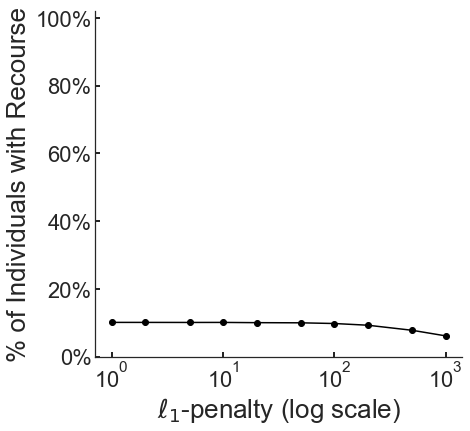

In [13]:
# feasibility plot
f, ax = create_figure(fig_size = (6, 6))
t_found = pd.Series(feasibility_df)
t_found.plot(ax = ax, color = 'black', marker='o')
plt.semilogx()
ax.set_xlabel(xlabel)
ax.set_ylabel('% of Individuals with Recourse')
ax.set_ylim(0, 1.02)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals = 0))
ax = fix_font_sizes(ax)
#f.savefig('%s_recourse_feasibility.pdf' % settings['audit_file_header'], bbox_inches = 'tight')
plt.plot()
#plt.close()


In [14]:
f.savefig('%s_recourse_feasibility.pdf' % settings['audit_file_header'], bbox_inches = 'tight')

[]

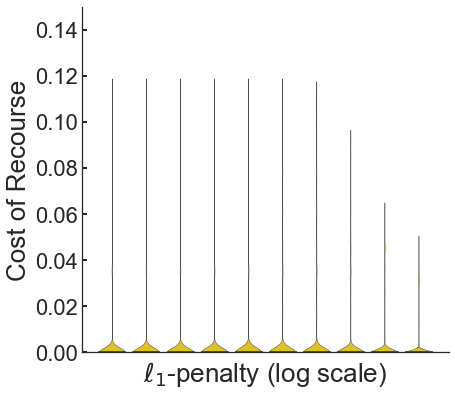

In [15]:

#########################################################

cost_df = {k: pd.DataFrame(v) for k, v in audit_results.items()}

# Note total_cost-> cost 
cost_df = pd.concat([cost_df[k]['cost'].to_frame('%f' % k) for k in sorted(cost_df.keys())], axis=1).replace([-np.inf, np.inf], np.nan)


# plot cost distribution
f, ax = create_figure(fig_size = (6, 6))
sns.violinplot(data = cost_df, ax = ax, linewidth = 0.5, cut = 0, inner = 'quartile', color = "gold", scale = 'width')
ax.set_xlabel(xlabel)
ax.set_ylabel('Cost of Recourse')
ax.set_ylim(bottom = 0, top = 0.15)
xtick_labels = []
# for xt in ax.get_xticklabels():
#     v = np.log10(float(xt.get_text()))
#     label = '$10^{%.0f}$' % v if v == np.round(v, 0) else ' '
#     xtick_labels.append(label)
ax.set_xticklabels(xtick_labels)

for l in ax.lines:
    l.set_linewidth(3.0)
    l.set_linestyle('-')
    l.set_solid_capstyle('butt')

ax = fix_font_sizes(ax)
plt.plot()

In [16]:
f.savefig('%s_recourse_cost_distribution.pdf' % settings['audit_file_header'], bbox_inches = 'tight')
plt.close()


# Store Median Cost

[]

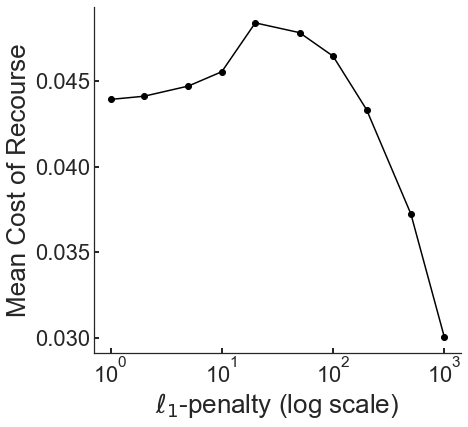

In [18]:
	    # store median cost
cost_df.median(axis = 0).to_csv('%s_median_cost_df.csv' % settings['audit_file_header'])

# plot the mean cost of recourse
f, ax = create_figure(fig_size = (6, 6))
ts_m = pd.Series(obj_val)
ax = ts_m.plot(ax = ax, color = 'black', marker = 'o')
plt.semilogx()
plt.xlabel(xlabel)
plt.ylabel('Mean Cost of Recourse')
ax = fix_font_sizes(ax)

plt.plot()


In [19]:
f.savefig('%s_recourse_cost.pdf' % settings['audit_file_header'], bbox_inches = 'tight')
plt.close()